# Task 1: Aggregate Statistics

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# File paths
feeds_csv_path = 'train/train_data_feeds.csv'
ads_csv_path = 'train/train_data_ads.csv'

In [2]:
# Load and optimize the ads dataset
ads_chunks = []
for chunk in pd.read_csv(ads_csv_path, chunksize=1000):
    chunk = chunk.dropna()  # Drop rows with NA values
    for col in chunk.select_dtypes(include=['int64', 'float64']).columns:
        if pd.api.types.is_integer_dtype(chunk[col]):
            chunk[col] = pd.to_numeric(chunk[col], downcast='signed')
        else:
            chunk[col] = pd.to_numeric(chunk[col], downcast='float')
    ads_chunks.append(chunk)
advertiser_df = pd.concat(ads_chunks, ignore_index=True)

# Load and optimize the feeds dataset
feeds_chunks = []
for chunk in pd.read_csv(feeds_csv_path, chunksize=1000):
    chunk = chunk.dropna()  # Drop rows with NA values
    for col in chunk.select_dtypes(include=['int64', 'float64']).columns:
        if pd.api.types.is_integer_dtype(chunk[col]):
            chunk[col] = pd.to_numeric(chunk[col], downcast='signed')
        else:
            chunk[col] = pd.to_numeric(chunk[col], downcast='float')
    feeds_chunks.append(chunk)
publisher_df = pd.concat(feeds_chunks, ignore_index=True)

print(f"Publisher DataFrame shape: {publisher_df.shape}")
print(f"Advertiser DataFrame shape: {advertiser_df.shape}")

Publisher DataFrame shape: (3123614, 28)
Advertiser DataFrame shape: (7675517, 35)


In [3]:
# Identify common user IDs between both datasets
common_user_ids = set(advertiser_df['user_id']).intersection(set(publisher_df['u_userId']))

# Filter ads dataset to include only rows with common user IDs
filtered_ads_df = advertiser_df[advertiser_df['user_id'].isin(common_user_ids)]

### Age Group Distribution

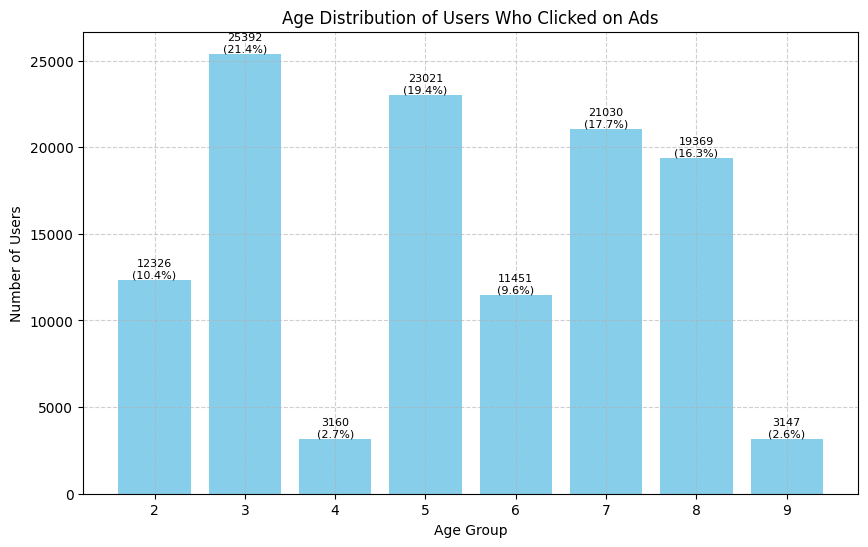

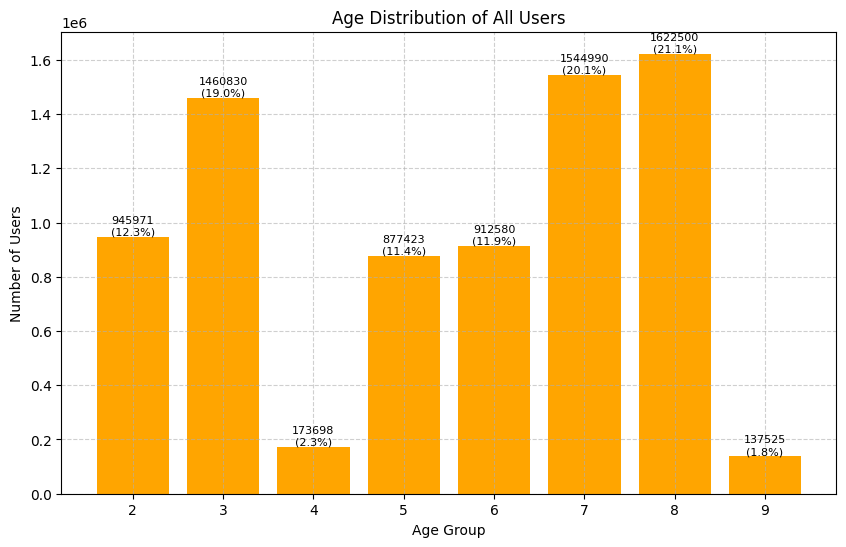

In [4]:
# Calculate the distribution of age groups for users who clicked on ads
age_counts = filtered_ads_df[filtered_ads_df['label'] == 1]['age'].value_counts().sort_index()

# Plot the age distribution
plt.figure(figsize=(10, 6))
plt.bar(age_counts.index, age_counts.values, color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.title('Age Distribution of Users Who Clicked on Ads')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(age_counts.index)

total_clicks = age_counts.sum()
for age, count in zip(age_counts.index, age_counts.values):
    percentage = (count / total_clicks) * 100
    plt.text(age, count + 0.5, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=8)

plt.show()


# Calculate the distribution of age groups for all users
age_counts_all = advertiser_df['age'].value_counts().sort_index()

# Plot the age distribution of all users
plt.figure(figsize=(10, 6))
plt.bar(age_counts_all.index, age_counts_all.values, color='orange')
plt.xlabel('Age Group')
plt.ylabel('Number of Users')
plt.title('Age Distribution of All Users')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(age_counts_all.index)

total_users = age_counts_all.sum()
for age, count in zip(age_counts_all.index, age_counts_all.values):
    percentage = (count / total_users) * 100
    plt.text(age, count + 0.5, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=8)

plt.show()


The age group distribution for users who clicked on ads shows that the most responsive groups are Age Group 3 (21.4%), Age Group 5 (19.4%), Age Group 7 (17.7%), and Age Group 8 (16.3%). This suggests that advertisements should be primarily targeted towards these age groups to maximize engagement. Age Groups 4 (2.7%) and 9 (2.6%) show the least engagement, indicating they are less effective for ad targeting. By focusing on the most responsive age groups, ad agencies can enhance the effectiveness of their campaigns and achieve better conversion rates.

In [5]:
from scipy.signal import find_peaks

# Separate users who clicked on ads
clicked_ads_df = advertiser_df[advertiser_df['label'] == 1]

def plot_features(df, clicked_df, features, feature_type):
    
    fig, axes = plt.subplots(len(features), 1, figsize=(10, 6 * len(features)))

    for i, feature in enumerate(features):
        ax = axes[i]

        # Plot histogram for all users
        sns.histplot(df[feature].dropna(), label='All Users', kde=False, ax=ax, color='lightblue', bins=30, stat='density')

        # Overlay KDE for users who clicked ads, with normalization
        kde = sns.kdeplot(clicked_df[feature].dropna(), label='Users Who Clicked Ads', ax=ax, color='orange', common_norm=False)

        ax.set_title(f'{feature.replace("_", " ").capitalize()} Distribution')
        ax.set_xlabel(feature.replace("_", " ").capitalize())
        ax.set_ylabel('Density')
        ax.legend(loc='upper left', bbox_to_anchor=(1,1))
        ax.grid(True, linestyle='--', alpha=0.6)

        # Extract KDE data if available
        if kde.get_lines():
            # Extract KDE data
            x, y = kde.get_lines()[0].get_data()
            # Find peaks (local maxima)
            peaks, _ = find_peaks(y)
            # Find troughs (local minima)
            troughs, _ = find_peaks(-y)
            # Annotate peaks
            for peak in peaks:
                ax.annotate(f'{int(x[peak])}', (x[peak], y[peak]), xytext=(5, 5), textcoords='offset points', arrowprops=dict(arrowstyle='->', lw=1.5), color='blue')
            # Annotate troughs
            for trough in troughs:
                ax.annotate(f'{int(x[trough])}', (x[trough], y[trough]), xytext=(5, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->', lw=1.5), color='red')

    plt.tight_layout()
    plt.show()

### Geographic Distribution 

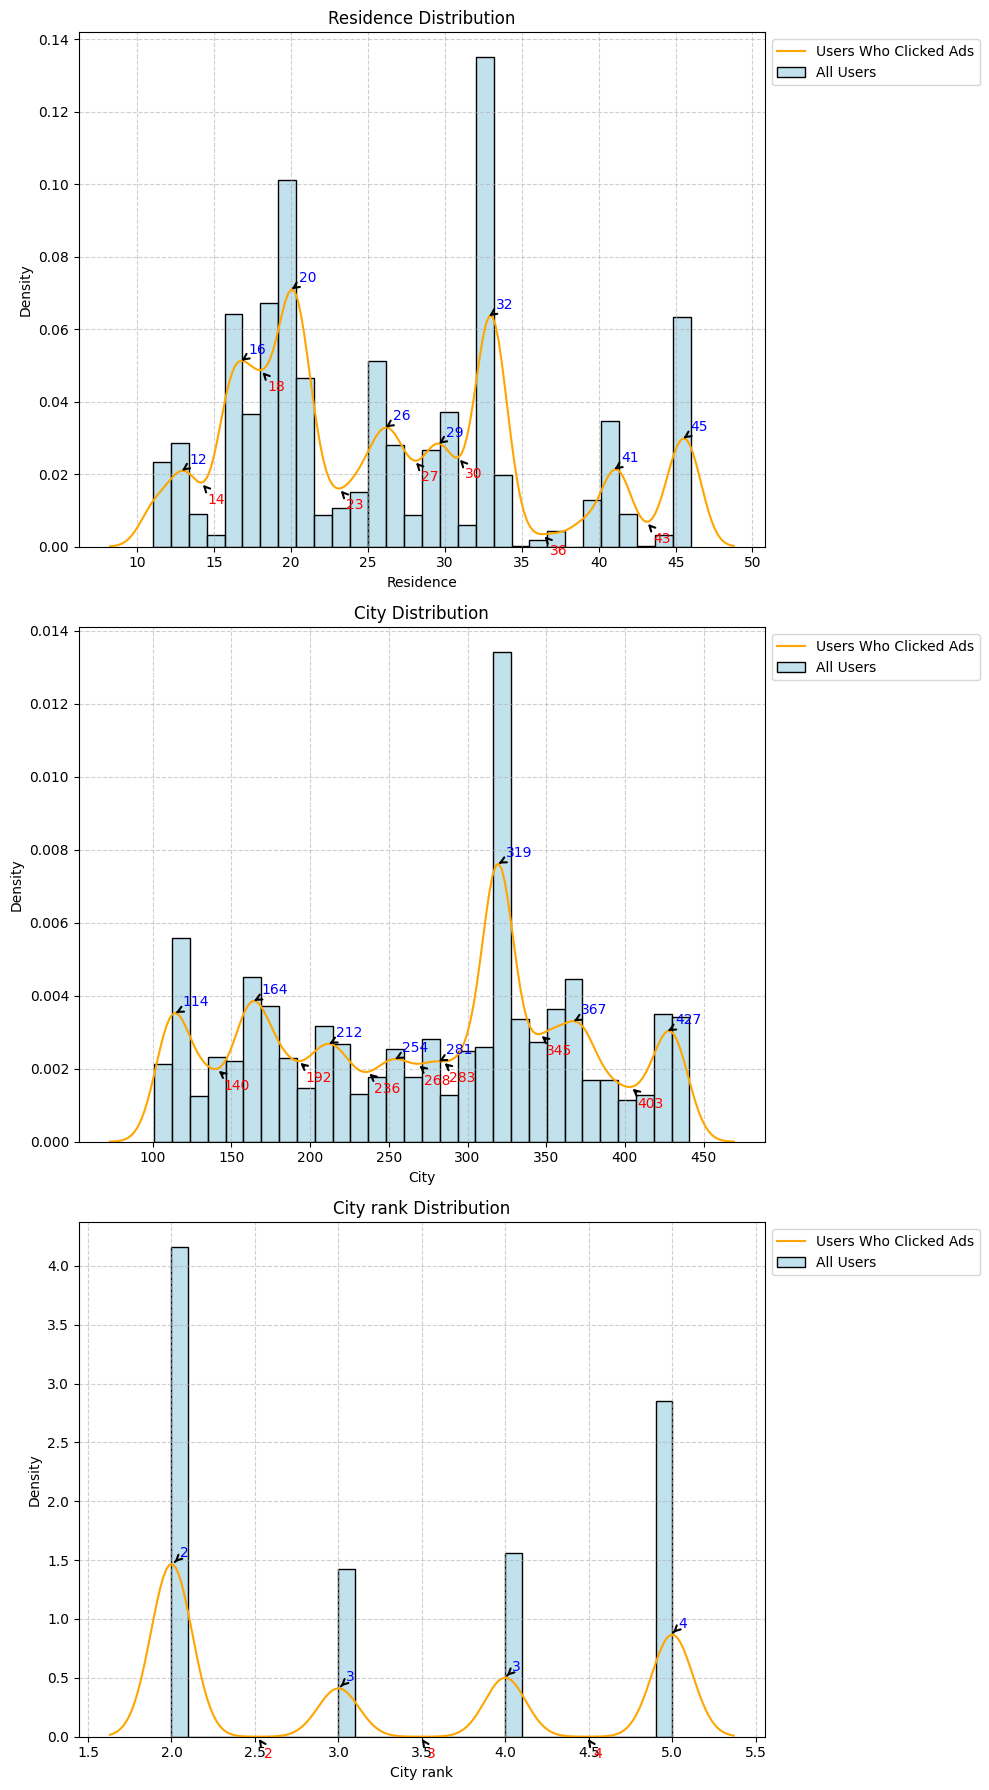

In [6]:
# Plot geographic features
geographic_features = ['residence', 'city', 'city_rank']
plot_features(advertiser_df, clicked_ads_df, geographic_features, 'geographic')


The geographic distribution analysis indicates that users who click on ads are primarily located in specific areas: for residence, notable peaks are at IDs 20, and 32 with troughs at IDs 23, and 36; for cities, significant peaks are at ID 319; and for city ranks, the highest engagement is seen at ranks 2. These patterns suggest that targeting ads in these high-density areas will optimize regional targeting and localization strategies, enhancing engagement and ad performance.

The geographic distribution analysis reveals that users in residences around 20 and 32, city 319, and city ranks 2 show higher ad engagement compared to the overall user base. These specific locations and ranks indicate where targeted advertising efforts can be more effective due to increased user engagement.

### Device Usage 

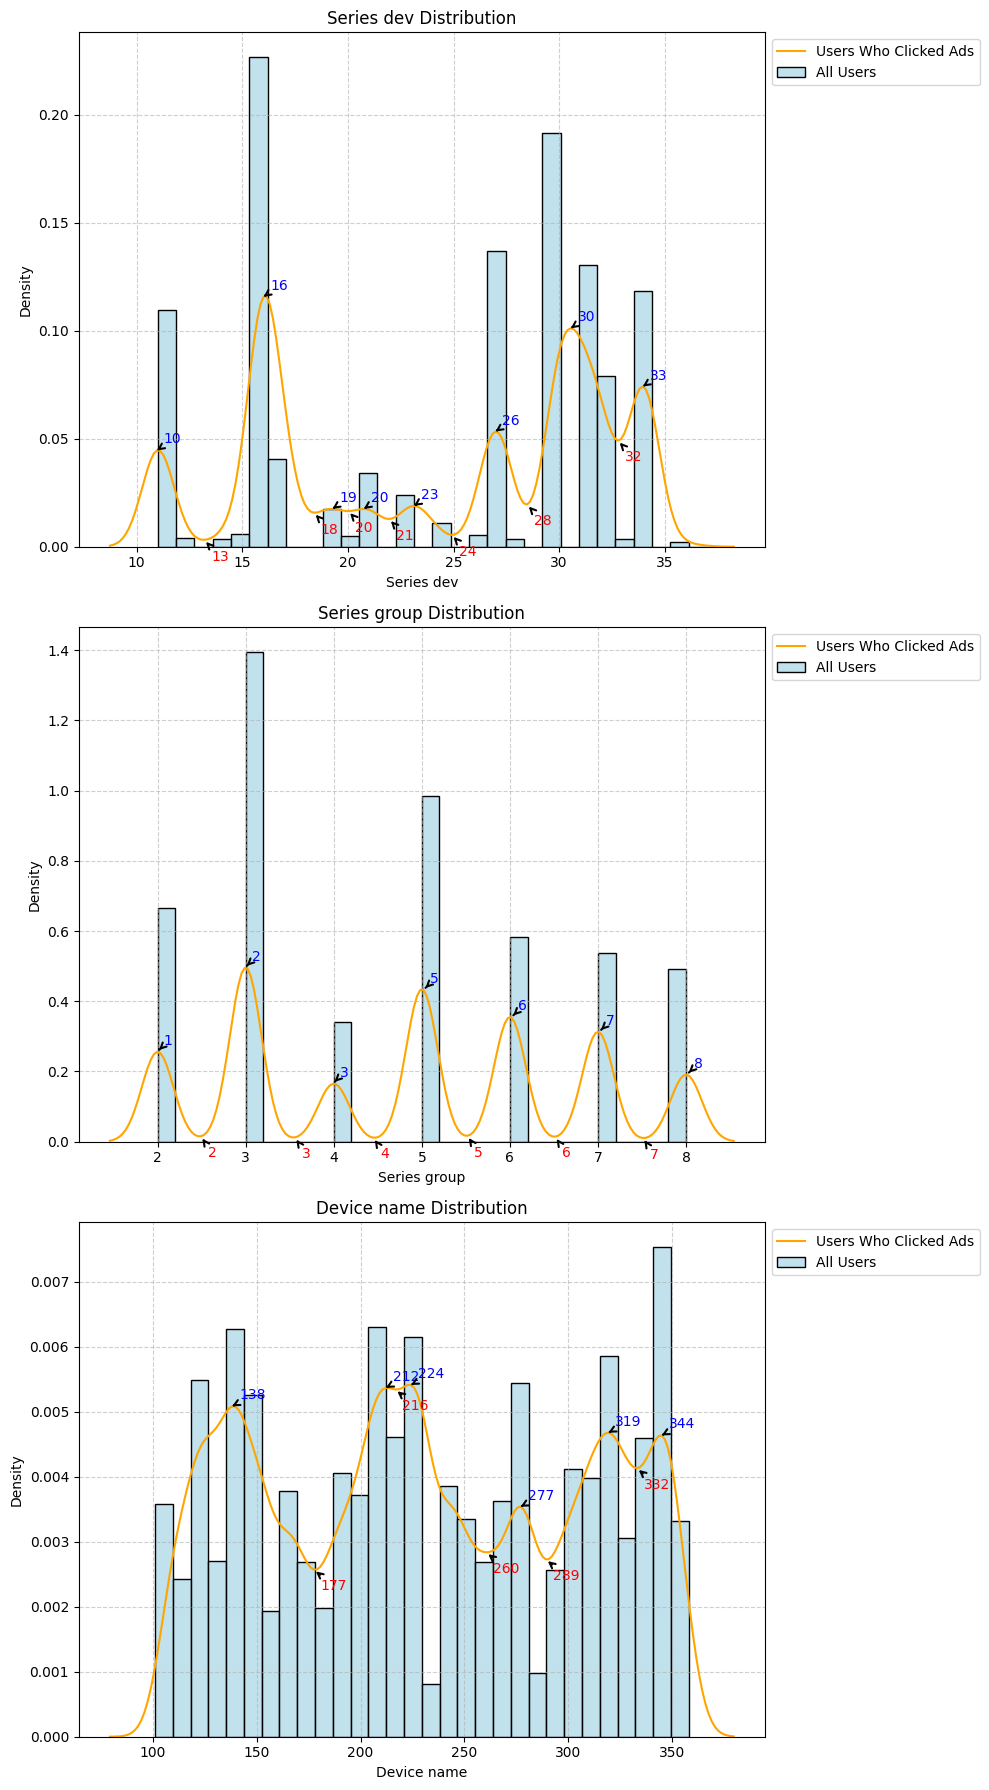

In [15]:
# Plot device usage features
device_usage_features = ['series_dev', 'series_group', 'device_name', 'device_size', 'net_type']
plot_features(advertiser_df, clicked_ads_df, device_usage_features, 'device usage')

The device usage analysis indicates that users who click on ads show preferences for certain device characteristics. 

Notable peaks are observed in the series_dev at IDs 16, and 30, in the series_group at IDs 2 and in the emui_dev at ID 20. For device_name, peaks are seen around IDs 138, 224, and 344. In terms of device_size, higher engagement is noted at sizes 2113, and 2405. Finally, for net_type, users predominantly use type 7. 

These insights indicate that targeted advertising efforts focusing on these specific device characteristics can be more effective due to higher user engagement in these segments.

### Engagement Patterns 

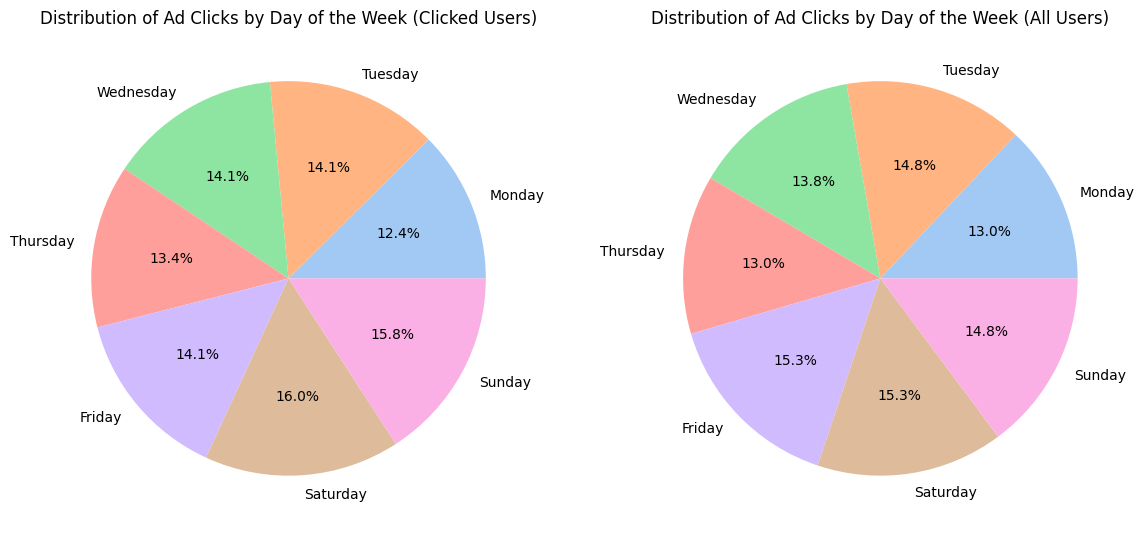

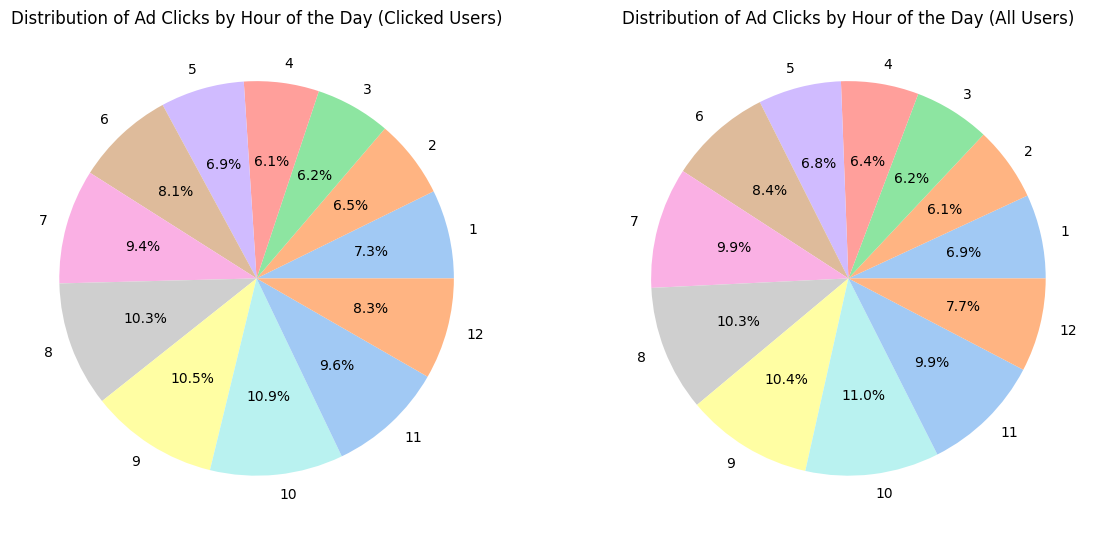

In [16]:
# Convert timestamp and extract day of the week and hour
advertiser_df['pt_d'] = pd.to_datetime(advertiser_df['pt_d'], format='%Y%m%d%H%M')
advertiser_df['day_of_week'] = advertiser_df['pt_d'].dt.day_name()
advertiser_df['hour'] = advertiser_df['pt_d'].dt.hour

clicked_ads_df = advertiser_df[advertiser_df['label'] == 1]

# Calculate distribution by day of the week
day_counts = advertiser_df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).fillna(0)
day_counts_clicked = clicked_ads_df['day_of_week'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).fillna(0)

# Plot pie chart for day of the week
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[1].pie(day_counts, labels=day_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axs[1].set_title('Distribution of Ad Clicks by Day of the Week (All Users)')
axs[0].pie(day_counts_clicked, labels=day_counts_clicked.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axs[0].set_title('Distribution of Ad Clicks by Day of the Week (Clicked Users)')
plt.show()

# Calculate distribution by hour of the day
hour_counts = advertiser_df['hour'].value_counts().sort_index()
hour_counts_clicked = clicked_ads_df['hour'].value_counts().sort_index()

# Plot pie chart for hour of the day
fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[1].pie(hour_counts, labels=hour_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axs[1].set_title('Distribution of Ad Clicks by Hour of the Day (All Users)')
axs[0].pie(hour_counts_clicked, labels=hour_counts_clicked.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
axs[0].set_title('Distribution of Ad Clicks by Hour of the Day (Clicked Users)')
plt.show()

The engagement patterns reveal that users who click on ads are most active on weekends, with Saturday and Sunday showing the highest engagement, at 16.0% and 15.8%, respectively. During the week, activity is relatively balanced, but Monday has the lowest engagement at 12.4%. In terms of the hour of the day, ad clicks peak during the late morning and early afternoon hours, specifically between 8 AM and 12 PM, with the highest engagement at 10 AM (10.9%) and 11 AM (10.4%). 

These insights suggest that ad campaigns should be scheduled to maximize visibility during these high-engagement periods, particularly on weekends and during late mornings to early afternoons, to optimize user engagement and ad performance.

### Content Preferences 

C:\Users\Daivy\AppData\Local\Temp\ipykernel_8332\2777038052.py:17: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kde = sns.kdeplot(clicked_df[feature].dropna(), label='Users Who Clicked Ads', ax=ax, color='orange', common_norm=False)


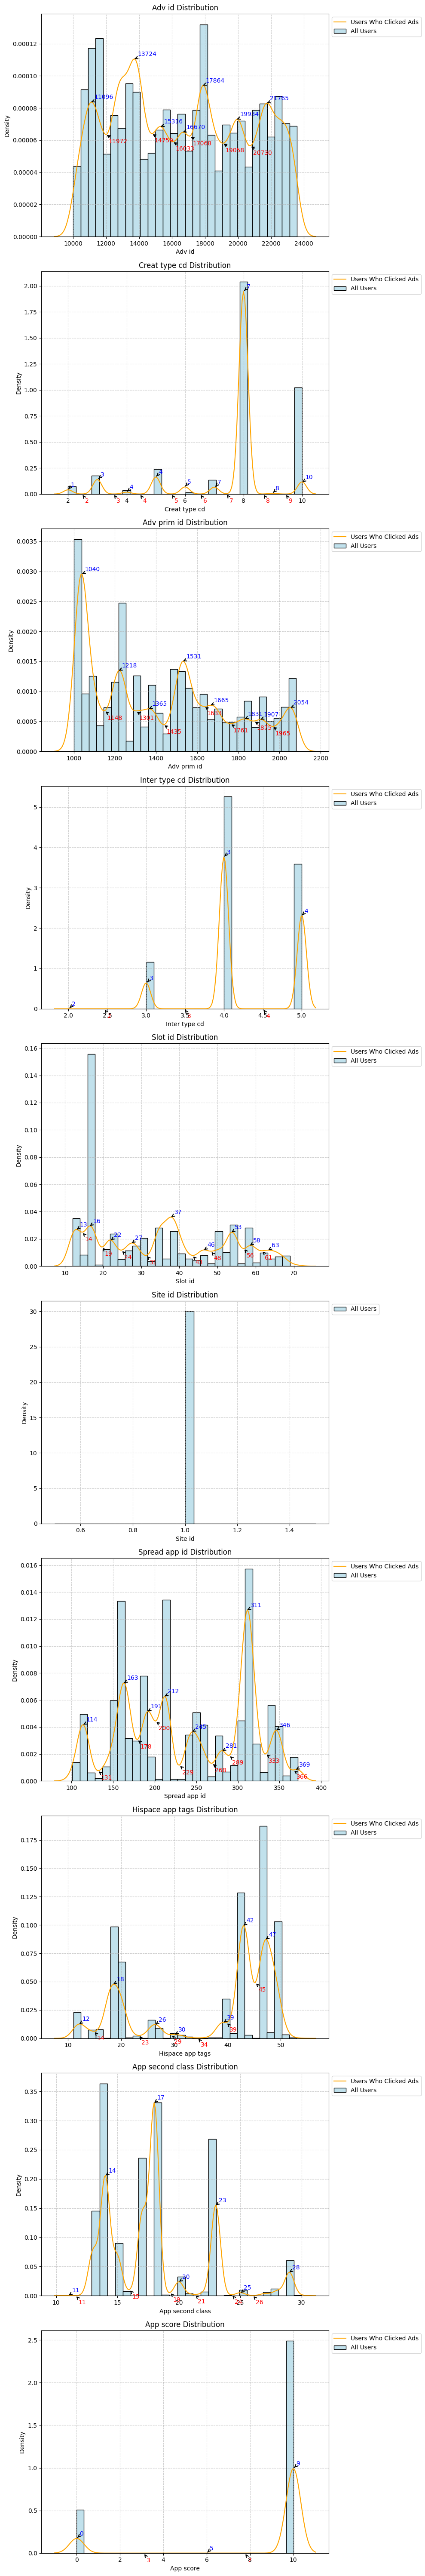

In [13]:
Ad_content_features = [
    'adv_id', 'creat_type_cd', 'adv_prim_id', 'inter_type_cd', 
    'slot_id', 'site_id', 'spread_app_id', 'hispace_app_tags', 
    'app_second_class', 'app_score'
]

# Plot Ad content features
plot_features(advertiser_df, clicked_ads_df, Ad_content_features, 'Ad Content')

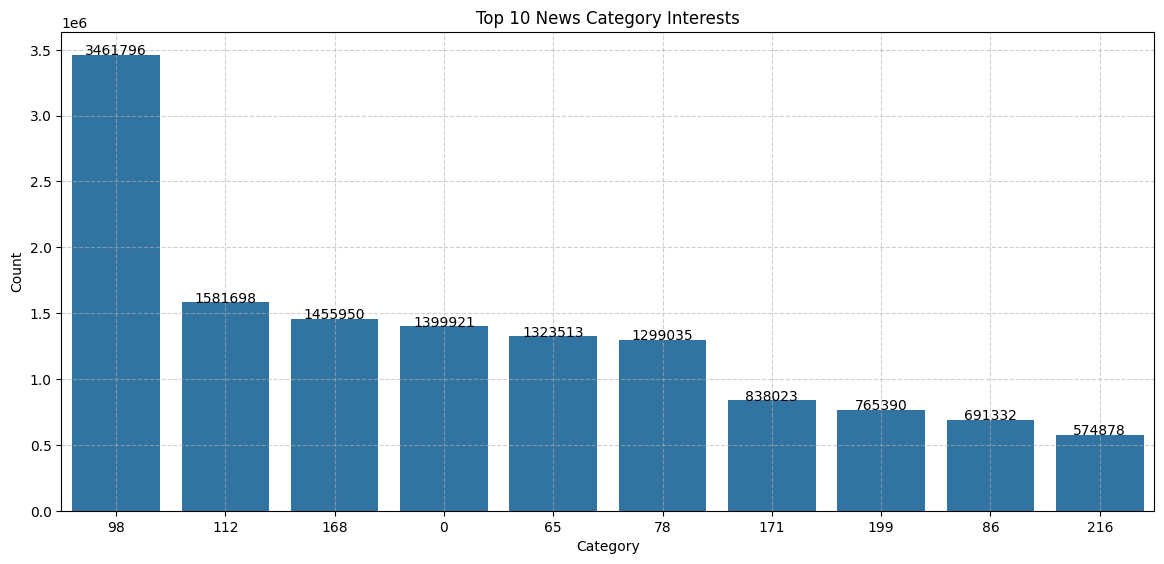

In [14]:
# Concatenate the interest columns with a separator and then split into individual interests
combined_interests = publisher_df[['u_newsCatInterestsST', 'u_newsCatInterests']].fillna('').agg('^'.join, axis=1)
all_interests = combined_interests.str.split('^').explode()

# Calculate the frequency of each unique interest
interest_counts = all_interests.value_counts().sort_values(ascending=False)

# Select the top 10 most common interests
top10_interests = interest_counts.head(10)

# Plot the distribution of the top 10 interests
plt.figure(figsize=(12, 6))
sns.barplot(x=top10_interests.index, y=top10_interests.values)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Top 10 News Category Interests')
plt.grid(True, linestyle='--', alpha=0.6)

# Add text annotations to the bars
for index, value in enumerate(top10_interests.values):
    plt.text(index, value + 0.5, str(value), ha='center')

plt.tight_layout(pad=2.0)
plt.show()

Under content preferences category 98 stands out as the most popular, with approximately 3.46 million users showing interest, followed by categories 112 and 168 with around 1.58 million and 1.46 million users, respectively. Other notable categories include 0, 65, 78, 171, 199, 86, and 216. These insights into user interests can guide the creation of more engaging advertisements by aligning ad content with popular news categories, thereby increasing click-through rates and user engagement.